In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Data Exploration

### Load data as pandas dataframes

In [2]:
users = pd.read_csv('./Data/yammer_users.csv')
events = pd.read_csv('./Data/yammer_events.csv')
emails = pd.read_csv('./Data/yammer_emails.csv')
rollup = pd.read_csv('./Data/dimension_rollup_periods.csv')

### Convert times to date-time standard

In [3]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [4]:
users['created_at'] = pd.to_datetime(users['created_at'])
users['activated_at'] = pd.to_datetime(users['activated_at'])

In [5]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [6]:
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

In [7]:
emails.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [8]:
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])

In [9]:
rollup.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1.0,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1.0,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1.0,2013-01-03 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1.0,2013-01-04 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1.0,2013-01-05 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-05 08:00:00,2013-01-06 08:00:00


In [10]:
rollup['time_id'] = pd.to_datetime(rollup['time_id'])
rollup['pst_start'] = pd.to_datetime(rollup['pst_start'])
rollup['pst_end'] = pd.to_datetime(rollup['pst_end'])
rollup['utc_start'] = pd.to_datetime(rollup['utc_start'])
rollup['utc_end'] = pd.to_datetime(rollup['utc_end'])

### Signup statistics

In general, how many users complete the signup process.

In [13]:
# Create subset of only "signup_flow" data
signup_flow = events[events['event_type'] == 'signup_flow']

# One-hot encoding of event types
account_creation_events = pd.get_dummies(signup_flow[['user_id', 'event_name']])
account_creation_events = account_creation_events.groupby('user_id').sum()

# Print head
account_creation_events[['event_name_complete_signup', 'event_name_create_user']].head()

,event_name_complete_signup,event_name_create_user
user_id,,
11768.0,1,1
11769.0,0,1
11770.0,1,1
11771.0,0,1
11772.0,0,1


In [14]:
complete_signup_likelihood = account_creation_events['event_name_complete_signup'].value_counts()[1] / \
                             account_creation_events['event_name_create_user'].value_counts()[1]

print('{:0.2f}% probability that user completes signup after account creation'.format(100 * complete_signup_likelihood))

50.42% probability that user completes signup after account creation


# Identifying where the dip occurs

Let's first create a merged dataframe from the users and events tables. This will let us accumulate important information from both.

In [16]:
user_events = users.merge(events, on='user_id')
user_events['week_id'] = user_events['occurred_at'].apply(lambda x: x.week)
user_events_counts = user_events.groupby('week_id').count()

We can see that the spike prior to the dip occurs at week 31 of the year 2014. This is the week of July 28, 2014 through August 3, 2014.

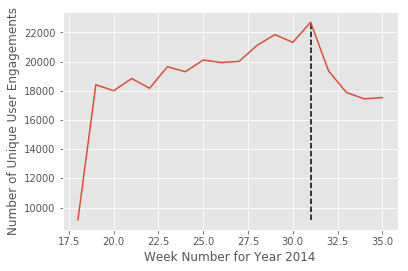

In [85]:
plt.plot(user_events_counts['created_at'])
plt.vlines(31, user_events_counts['created_at'].min(), 
           user_events_counts['created_at'].max(), linestyle='--')
plt.xlabel('Week Number for Year 2014')
plt.ylabel('Number of Unique User Engagements')
plt.show()

# Identifying pre and post dip trends

In [86]:
pre_dip = user_events[user_events['week_id'] <= 31]
post_dip = user_events[user_events['week_id'] > 31]

Noticeably, there is a huge drop in the number of companies that with weekly activities

In [87]:
pre_dip_companies = set(pre_dip['company_id'].unique())
post_dip_companies = set(post_dip['company_id'].unique())

print("Number of companies prior: {:d}".format(len(pre_dip_companies)))
print("Number of companies after: {:d}".format(len(post_dip_companies)))
print("Number of companies that remained: {:d}".format(len(pre_dip_companies.intersection(post_dip_companies))))

Number of companies prior: 5634
Number of companies after: 2650
Number of companies that remained: 1334


We don't see much change in likelihood of users completing the signup process.

In [88]:
# Create subset of only "signup_flow" data
signup_flow = pre_dip[pre_dip['event_type'] == 'signup_flow']

# One-hot encoding of event types
account_creation_events = pd.get_dummies(signup_flow[['user_id', 'event_name']])
account_creation_events = account_creation_events.groupby('user_id').sum()

# Print head
account_creation_events[['event_name_complete_signup', 'event_name_create_user']].head()

# Get fraction
complete_signup_likelihood = account_creation_events['event_name_complete_signup'].value_counts()[1] / \
                             account_creation_events['event_name_create_user'].value_counts()[1]

print('Prior to dip, {:0.2f}% probability that user completes signup after account creation'.format(100 * complete_signup_likelihood))

# Create subset of only "signup_flow" data
signup_flow = post_dip[post_dip['event_type'] == 'signup_flow']

# One-hot encoding of event types
account_creation_events = pd.get_dummies(signup_flow[['user_id', 'event_name']])
account_creation_events = account_creation_events.groupby('user_id').sum()

# Print head
account_creation_events[['event_name_complete_signup', 'event_name_create_user']].head()

# Get fraction
complete_signup_likelihood = account_creation_events['event_name_complete_signup'].value_counts()[1] / \
                             account_creation_events['event_name_create_user'].value_counts()[1]

print('After dip, {:0.2f}% probability that user completes signup after account creation'.format(100 * complete_signup_likelihood))

Prior to dip, 49.95% probability that user completes signup after account creation
After dip, 51.80% probability that user completes signup after account creation


There are no changes to the languages or the countries in which the activities originate, after the dip.

In [89]:
pre_dip_languages = set(pre_dip['language'].unique())
post_dip_languages = set(post_dip['language'].unique())

print("Number of languages prior: {:d}".format(len(pre_dip_languages)))
print("Number of languages after: {:d}".format(len(post_dip_languages)))
print("Number of languages that remained: {:d}".format(len(pre_dip_languages.intersection(post_dip_languages))))

Number of languages prior: 12
Number of languages after: 12
Number of languages that remained: 12


In [90]:
pre_dip_locations = set(pre_dip['location'].unique())
post_dip_locations = set(post_dip['location'].unique())

print("Number of countries prior: {:d}".format(len(pre_dip_locations)))
print("Number of countries after: {:d}".format(len(post_dip_locations)))
print("Number of countries that remained: {:d}".format(len(pre_dip_locations.intersection(post_dip_locations))))

Number of countries prior: 47
Number of countries after: 47
Number of countries that remained: 47


In [91]:
pre_dip_devices = set(pre_dip['device'].unique())
post_dip_devices = set(post_dip['device'].unique())

print("Number of devices prior: {:d}".format(len(pre_dip_devices)))
print("Number of devices after: {:d}".format(len(post_dip_devices)))
print("Number of devices that remained: {:d}".format(len(pre_dip_devices.intersection(post_dip_devices))))

Number of devices prior: 26
Number of devices after: 26
Number of devices that remained: 26


In [321]:
event_name = ['home_page', 'like_message', 'login', 
                'search_autocomplete', 'search_run',
                'send_message', 'view_inbox']

In [322]:
engagement_events = user_events[user_events['event_type'] == 'engagement']
engagement_count = engagement_events.groupby(['week_id', 'event_name']).count()[['user_id']]
engagement_count = engagement_count.unstack()['user_id']

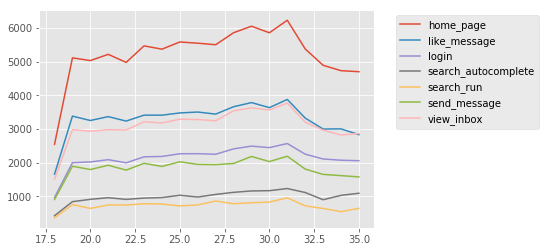

In [323]:
for name in event_name:
    plt.plot(engagement_count[[name]], label=name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [324]:
engagement_events = user_events[user_events['event_type'] == 'engagement']
engagement_mean = engagement_events.groupby(['week_id', 'event_name']).mean()[['user_id']]
engagement_mean = engagement_mean.unstack()['user_id']

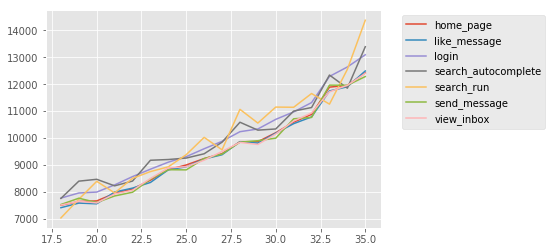

In [325]:
for name in event_name:
    plt.plot(engagement_mean[[name]], label=name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# What's going on?

On July 24, 2014, Microsoft announced that Yammer development was being moved into the Office 365 development team, and Sacks announced that he was leaving Microsoft and Yammer.